**install requirements**

In [ ]:
# !pip install importnb
# !pip install torch torchvision torchaudio
# !pip install openai

**Run main notebook directly and load result to dataframe**

In [ ]:
# from importnb import Notebook
# import json
# import pandas as pd
# import matplotlib.pyplot as plt

# with Notebook():
#     import main  

# results = main2.results  
# df = pd.json_normalize(results)

# print(df.head())

**Load existing json file to dataframe**

In [21]:
import os
import json
import pandas as pd

# Define the path to the results.json file
results_file = os.path.abspath(os.path.join("..", "data", "processed", "results.json"))

# Load the results JSON file
if os.path.exists(results_file):
    with open(results_file, "r") as f:
        results = json.load(f)

    df = pd.json_normalize(results)

    print(df.head())
else:
    print(f"File not found: {results_file}")

                                               query expected  \
0  PROVISION OF MISSION CRITICAL PUSH-TO-TALK (PT...     E017   
1  Year 7 Period Contract for Maintenance of Mobi...     E073   
2  Year 3 to Year 10 Preventive Maintenance of Mo...     E073   
3  Provision of Hiring Services for Cars, VIP Bus...     E021   
4  SURVEILLANCE TESTING FOR BALLISTIC PLATE LEVEL...     E073   

                                expected_description  \
0  Telecommunications511999 - Direct Project: Others   
1  Maintenance: Other Equipment & ToolsNot Applic...   
2  Maintenance: Other Equipment & ToolsNot Applic...   
3                      Local TransportNot Applicable   
4  Maintenance: Other Equipment & ToolsNot Applic...   

                                     retrieved_top_5  \
0  [{'material_number': 'E123', 'description': 'S...   
1  [{'material_number': 'E091', 'description': 'F...   
2  [{'material_number': 'E114', 'description': 'F...   
3  [{'material_number': 'E004', 'description': '

**Calculate Overall Metrics**

In [23]:
import pandas as pd
from sklearn.metrics import f1_score

accuracy = df["is_correct"].mean()
print(f"Overall Accuracy: {accuracy:.2%}")

# Initialize a dictionary to store F1 scores for each material number
f1_scores = {}

# Get the list of all unique material numbers
all_material_numbers = set(df['expected']).union(*df['retrieved_material_numbers'])

# Calculate F1 score for each material number
for material_number in all_material_numbers:
    y_true = []
    y_pred = []
    for _, row in df.iterrows():
        # True label: 1 if the expected material number matches the current material number, else 0
        y_true.append(1 if row['expected'] == material_number else 0)
        # Predicted label: 1 if the current material number is in the retrieved list, else 0
        y_pred.append(1 if material_number in row['retrieved_material_numbers'] else 0)
    # Calculate F1 score for the current material number
    score = f1_score(y_true, y_pred, zero_division=0)
    f1_scores[material_number] = score

# Convert the F1 scores dictionary to a DataFrame for easy sorting
f1_scores_df = pd.DataFrame(list(f1_scores.items()), columns=['material_number', 'f1_score'])

# Sort the F1 scores in descending order
sorted_f1_scores = f1_scores_df.sort_values(by='f1_score', ascending=False)

# Display the top 10 material numbers by F1 score
print("Top 10 Material Numbers by F1 Score:")
print(sorted_f1_scores.head(10))

# Display the bottom 10 material numbers by F1 score
print("\nBottom 10 Material Numbers by F1 Score:")
print(sorted_f1_scores.tail(10))

Overall Accuracy: 16.73%
Top 10 Material Numbers by F1 Score:
   material_number  f1_score
41            E009  0.608534
56            E043  0.215686
16            E033  0.201285
11            E082  0.189474
0             E064  0.165242
40            E016  0.148362
55            E063  0.119403
43            E017  0.105263
39            E031  0.093023
34            E021  0.074074

Bottom 10 Material Numbers by F1 Score:
   material_number  f1_score
12            E046       0.0
32            E026       0.0
15            E050       0.0
29            E120       0.0
27            E023       0.0
19            E091       0.0
20            E111       0.0
24            E011       0.0
23            E022       0.0
5             E115       0.0


**Confidence vs. Accuracy**

C:\Users\Jason\AppData\Local\Temp\ipykernel_26760\1612922818.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_score = df.groupby("score_bin")["is_correct"].mean()


Accuracy by Similarity Score Range:
score_bin
(0, 40]           NaN
(40, 60]     0.000000
(60, 80]     0.317612
(80, 100]    0.095872
Name: is_correct, dtype: float64


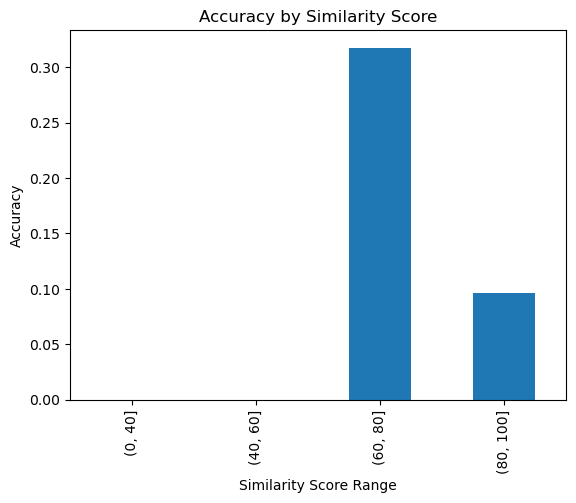

In [13]:
from matplotlib import pyplot as plt

# Bin similarity scores
bins = [0, 40, 60, 80, 100]
df["score_bin"] = pd.cut(df["similarity_scores"].apply(lambda x: x[0]), bins)
accuracy_by_score = df.groupby("score_bin")["is_correct"].mean()

print("Accuracy by Similarity Score Range:")
print(accuracy_by_score)

# Plot accuracy by similarity score
accuracy_by_score.plot(kind="bar", title="Accuracy by Similarity Score")
plt.xlabel("Similarity Score Range")
plt.ylabel("Accuracy")
plt.show()

**Analyze Incorrect Predictions and their description lengths**

Most Common Incorrect Matches with Description Lengths:
E074 - Maintenance-ICT Hardware(OOE only) (Count: 31224, Length: 34 characters)
E076 - Maintenance-ICT Hardware Integrated with Software(OOE only) (Count: 27760, Length: 59 characters)
E071 - Maintenance-Office Equipment(OOE only) (Count: 23853, Length: 38 characters)
E008 - Service for Office Supplies(OOE only) (Count: 22664, Length: 37 characters)
E075 - Maintenance-ICT Software(OOE only) (Count: 21980, Length: 34 characters)
E113 - Fixed Asset Purchase-ICT Hardware (Project) (Count: 15148, Length: 43 characters)
E114 - Fixed Asset Purchase-ICT Software (Project) (Count: 13194, Length: 43 characters)
E016 - Service for Other Supplies(OOE only) (Count: 10841, Length: 36 characters)
E111 - Fixed Asset Purchase-Scientific Equipment (Project) (Count: 10581, Length: 51 characters)
E115 - Fixed Asset Purchase-ICT Hardware Integrated with Software (Project) (Count: 8365, Length: 68 characters)


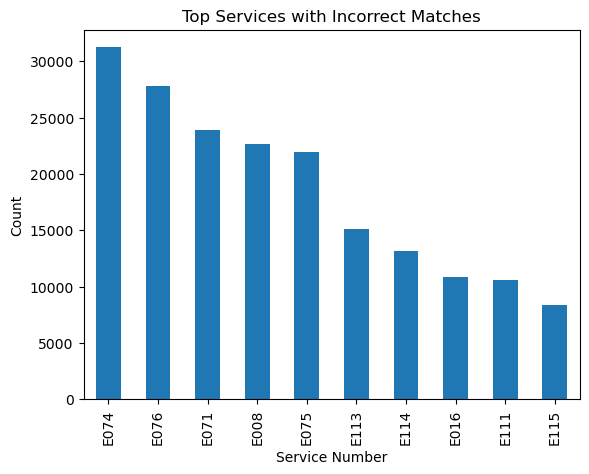

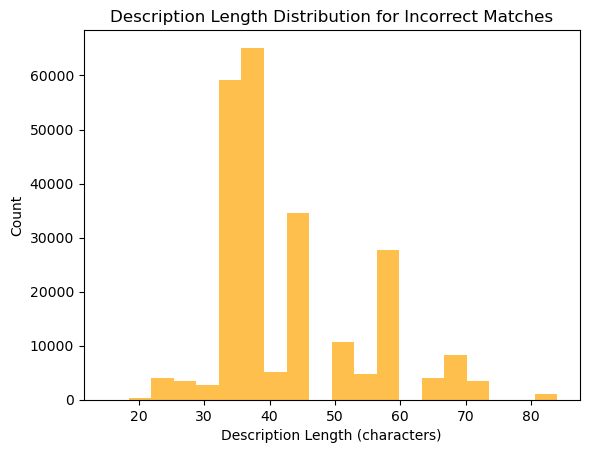

In [15]:
incorrect_df = df[~df["is_correct"]]

# Flatten the retrieved material numbers
incorrect_materials = incorrect_df.explode("retrieved_material_numbers")

def get_description_for_material(material_number, top_5_matches):
    for match in top_5_matches:
        if match["material_number"] == material_number:
            return match["description"]
    return "No description available"

incorrect_materials["retrieved_descriptions"] = incorrect_materials.apply(
    lambda row: get_description_for_material(row["retrieved_material_numbers"], row["retrieved_top_5"]),
    axis=1
)

# Add a column for description lengths
incorrect_materials["description_length"] = incorrect_materials["retrieved_descriptions"].apply(
    lambda desc: len(desc) if isinstance(desc, str) else 0
)

# Count the top incorrect material numbers
common_incorrect_matches = incorrect_materials["retrieved_material_numbers"].value_counts().head(10)

# Map to each material number
material_to_description = incorrect_materials.drop_duplicates("retrieved_material_numbers").set_index(
    "retrieved_material_numbers"
)[["retrieved_descriptions", "description_length"]].to_dict("index")

# print rows
print("Most Common Incorrect Matches with Description Lengths:")
for material_number, count in common_incorrect_matches.items():
    desc_info = material_to_description.get(material_number, {})
    description = desc_info.get("retrieved_descriptions", "No description available")
    desc_length = desc_info.get("description_length", 0)
    print(f"{material_number} - {description} (Count: {count}, Length: {desc_length} characters)")

# chart for top incorrect matches
common_incorrect_matches.plot(kind="bar", title="Top Services with Incorrect Matches")
plt.xlabel("Service Number")
plt.ylabel("Count")
plt.show()

# chart for description length distribution
incorrect_materials["description_length"].plot(kind="hist", bins=20, alpha=0.7, color="orange", title="Description Length Distribution for Incorrect Matches")
plt.xlabel("Description Length (characters)")
plt.ylabel("Count")
plt.show()

**Description length analysis for correct matches**

Most Common Correct Matches with Description Lengths:
E074 - Maintenance-ICT Hardware(OOE only) (Count: 3064, Length: 34 characters)
E071 - Maintenance-Office Equipment(OOE only) (Count: 2799, Length: 38 characters)
E076 - Maintenance-ICT Hardware Integrated with Software(OOE only) (Count: 2649, Length: 59 characters)
E075 - Maintenance-ICT Software(OOE only) (Count: 1964, Length: 34 characters)
E064 - Maintenance-Vessels(OOE only) (Count: 1781, Length: 29 characters)
E008 - Service for Office Supplies(OOE only) (Count: 1558, Length: 37 characters)
E073 - Maintenance-Other Equipment & Tools(OOE only) (Count: 1401, Length: 45 characters)
E103 - Fixed Asset Purchase-Vessels (Project) (Count: 1090, Length: 38 characters)
E082 - Staff Training(OOE only) (Count: 848, Length: 24 characters)
E049 - Maintenance-Mechanical & Electrical System of Building(OOE only) (Count: 829, Length: 64 characters)


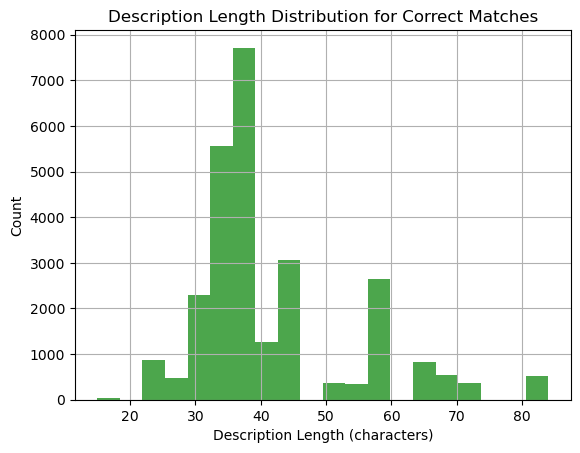

In [17]:
correct_df = df[df["is_correct"]]
correct_materials = correct_df.explode("retrieved_material_numbers")

correct_materials["retrieved_descriptions"] = correct_materials.apply(
    lambda row: get_description_for_material(row["retrieved_material_numbers"], row["retrieved_top_5"]),
    axis=1
)

# Add a column for description lengths
correct_materials["description_length"] = correct_materials["retrieved_descriptions"].apply(
    lambda desc: len(desc) if isinstance(desc, str) else 0
)

# Count the top correct material numbers
common_correct_matches = correct_materials["retrieved_material_numbers"].value_counts().head(10)

# Map to material numbers
material_to_description_correct = correct_materials.drop_duplicates("retrieved_material_numbers").set_index(
    "retrieved_material_numbers"
)[["retrieved_descriptions", "description_length"]].to_dict("index")

# print rows
print("Most Common Correct Matches with Description Lengths:")
for material_number, count in common_correct_matches.items():
    desc_info = material_to_description_correct.get(material_number, {})
    description = desc_info.get("retrieved_descriptions", "No description available")
    desc_length = desc_info.get("description_length", 0)
    print(f"{material_number} - {description} (Count: {count}, Length: {desc_length} characters)")

# chart of description lengths distribution
correct_materials["description_length"].hist(bins=20, alpha=0.7, color="green", label="Correct Matches")
plt.title("Description Length Distribution for Correct Matches")
plt.xlabel("Description Length (characters)")
plt.ylabel("Count")
#plt.legend()
plt.show()

**Query Length Analysis**

Accuracy by Query Length:
query_length_bin
(0, 50]       0.056872
(50, 100]     0.180026
(100, 150]    0.111354
(150, 200]    0.115307
Name: is_correct, dtype: float64


C:\Users\Jason\AppData\Local\Temp\ipykernel_26760\3317086258.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_length = df.groupby("query_length_bin")["is_correct"].mean()


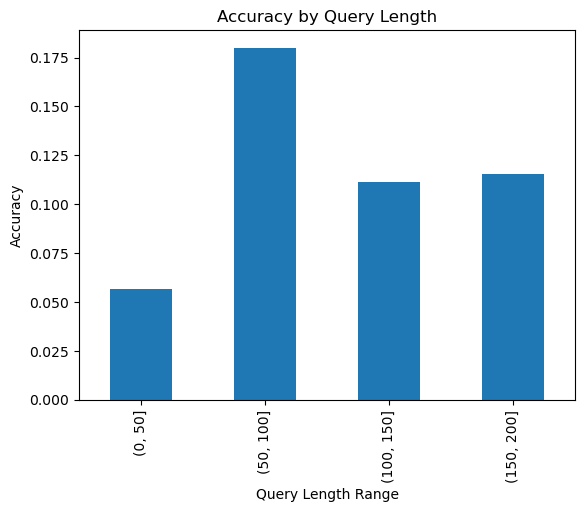

In [19]:
# Calculate query lengths
df["query_length"] = df["query"].apply(len)

# Group accuracy by query length ranges
bins = [0, 50, 100, 150, 200]
df["query_length_bin"] = pd.cut(df["query_length"], bins)
accuracy_by_length = df.groupby("query_length_bin")["is_correct"].mean()

print("Accuracy by Query Length:")
print(accuracy_by_length)

# Plot accuracy by query length
accuracy_by_length.plot(kind="bar", title="Accuracy by Query Length")
plt.xlabel("Query Length Range")
plt.ylabel("Accuracy")
plt.show()